<a href="https://colab.research.google.com/github/changhoonhahn/galevo23-tutorials/blob/main/sbi_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Simulation-Based Inference (SBI)
Jan./Feb. 2023 | [KITP-CCA Workshop: Data Driven Galaxy Evolution](https://datadrivengalaxyevolution.github.io/#ccaweek)

[ChangHoon Hahn](https://changhoonhahn.github.io/) [Princeton] 

In [1]:
# install some packages that we're going to use in this tutorial
!pip install git+https://github.com/changhoonhahn/provabgs
!pip install corner

  Created wheel for speclite: filename=speclite-0.16-py3-none-any.whl size=366403 sha256=e1436e8eb6d691e8e646711bf9d97e7f433ef3dfe40fe6f20e679b514cfaeed9
  Stored in directory: /root/.cache/pip/wheels/76/af/86/1cb7f93613095195a7f226e8d85fed9a6f1299b819115e7bcb
Successfully built provabgs speclite
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
from astropy import units as U
# import provabgs inference module
from provabgs import infer as Infer
# import provabgs SPS model module
from provabgs import models as Models
# import bandpass filters from speclite
from speclite import filters as specFilter

# make pretty plots
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

/usr/local/lib/python3.8/dist-packages/provabgs/models.py:23: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


# 0. Quick primer on `provabgs`
Before we begin, lets start with a quick primer on `provabgs`, which we'll use throughout the tutorial as an example. 

Briefly, `provabgs` provides a state-of-the-art stellar population synthesis (SPS) model based on a non-parametric prescription for star formation history, a metallicity history that varies over the age of the galaxy, and a flexible dust prescription. It has neural network emulator ([Kwon, Hahn, Alsing 2022](https://ui.adsabs.harvard.edu/abs/2022arXiv220914323K)) for the SPS model that enables fast model evaluations. For further details on `provabgs` check out the [documentation](https://changhoonhahn.github.io/provabgs/current/) and references therein. 

In [3]:
# declare SPS model. NMF here stands for non-negative matrix factorization, 
# which is what we use for our SFH and ZH.
m_sps = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


(0.0, 15.0)

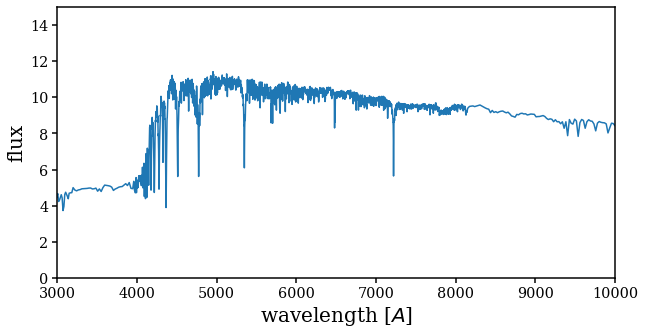

In [4]:
# using this SPS model, we can quickly generate a model SED for an arbitrary 
# set of SPS parameters: 
theta_sps = np.array([
      10.0, # logMstar
      1.0, # beta0
      0.0, # beta1
      0.0, # beta2
      0.0, # beta3
      0.0, # starburst component fraction
      1.0, # starburst time
      1e-3, # gamma0  
      1e-3, # gamma1
      1.0, # optical depth of birth cloud
      1.0, # optical depth of ISM 
      0.0  # dust index
      ])

# generate SED
w, f = m_sps.sed(theta_sps, 0.1) # at redshift = 0.1

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(w, f)
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(0., 15)

# 1. Constructing a Forward Model with `provabgs`

Now lets construct a simple forward model based on the `provabgs` SPS model. To keep things simple, lets keep everything in 1D: the only input/free parameter for our forward model is $M_*$ and it simulates **synethic observed** $r$-band magnitude.

I want to emphasize here that the forward model **must realistically model noise, selection, and observational systematics**. Accounting for noise, selection, and systematics is a requirement for *any* inference. In the standard approach, this point is often obfuscated because it's often assumed that the likelihood "takes care of it". However, this is often not the case and the assumption must be tested. 
In simulation-based inference, accounting for these effects is much more explicit since it has to be incorporated into the forward model. *This is a feature, not a bug*!


In [5]:
def sed(logmstar, zred): 
  ''' SPS model that outputs noiseless model SED given log(M*) and redshift. 
  '''
  # SPS parameters. Only log(M*) is a free parameter, the others are hardcoded
  # for simplicity
  theta_sps = np.array([
      logmstar,
      1.0, # beta0
      0.0, # beta1
      0.0, # beta2
      0.0, # beta3
      0.0, # starburst component fraction
      1.0, # starburst time
      1e-3, # gamma0  
      1e-3, # gamma1
      1.0, # optical depth of birth cloud
      1.0, # optical depth of ISM 
      0.0  # dust index
      ])
  w, f = m_sps.sed(theta_sps, zred)
  return w, f

# load decam r-band filter object 
r_pass = specFilter.load_filters('decam2014-r')

def r_model(w, f): 
  ''' convolve model SED with r-band filter and return noiseless r-band magnitude
  '''
  flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
  maggies = r_pass.get_ab_maggies(flux_z, wavelength=w_z)
  return 22.5 - 2.5 * np.log10(maggies.as_array()[0][0] * 1e9)

def noise_model(r): 
  ''' simple Gaussian noise model with fixed sigma = 0.1 
  I want to note that this is equivalent to a Gaussian likelihood with width
  sigma = 0.1
  '''
  noise = np.random.normal(0.0, 0.1)
  return r + noise

def forwardmodel0(logmstar): 
  w, f = sed(logmstar, 0.1) # model SD
  r_nonoise = r_model(w, f) # model r-band magnitude
  r_noise = noise_model(r_nonoise) # forward modeled r-band magnitude
  return r_noise

Now lets forward model synthetic observations using parameters drawn from our prior: 
$$p(\log M_*) = \mathcal{N}(10.5, 0.2)$$

Recall from the talk, that this is equivalent to sampling the joint distribution $p(\log M_*, X)$. 

In [6]:
thetas = 10.5 + 0.2 * np.random.normal(size=10000)
Xs = np.array([forwardmodel0(tt) for tt in thetas])

(19.5, 15.0)

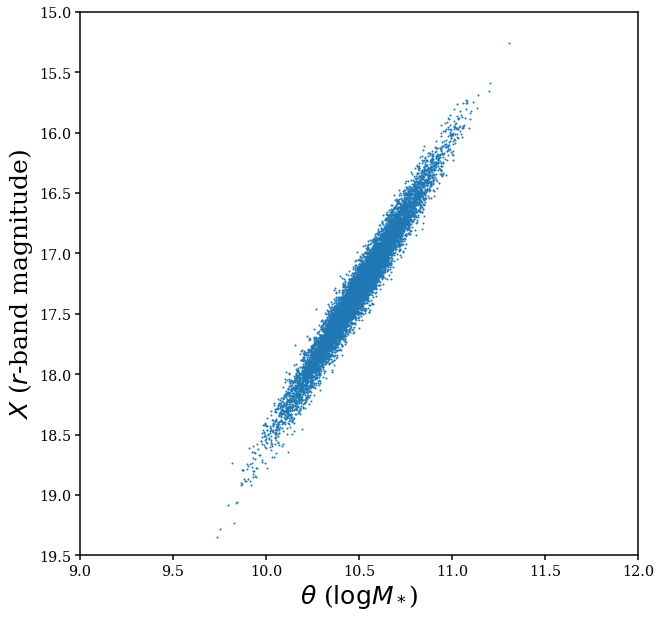

In [7]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.scatter(thetas, Xs, s=1)
sub.set_xlabel(r'$\theta$ ($\log M_*$)', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel('$X$ ($r$-band magnitude)', fontsize=25)
sub.set_ylim(19.5, 15.)

# 2. SBI Example 1: Approximate Bayesian Computation (ABC) in 1D
Now we have all the ingredients to do simulation-based inference using ABC. 

Lets say we observe a galaxy with $r$-band magnitude: 
$$X_{\rm obs} = 17$$
and we want to infer the posterior on $\log M_*$: 
$$p(\log M_*\,|\,X_{\rm obs})$$

In [8]:
Xobs = 17.

(19.5, 15.0)

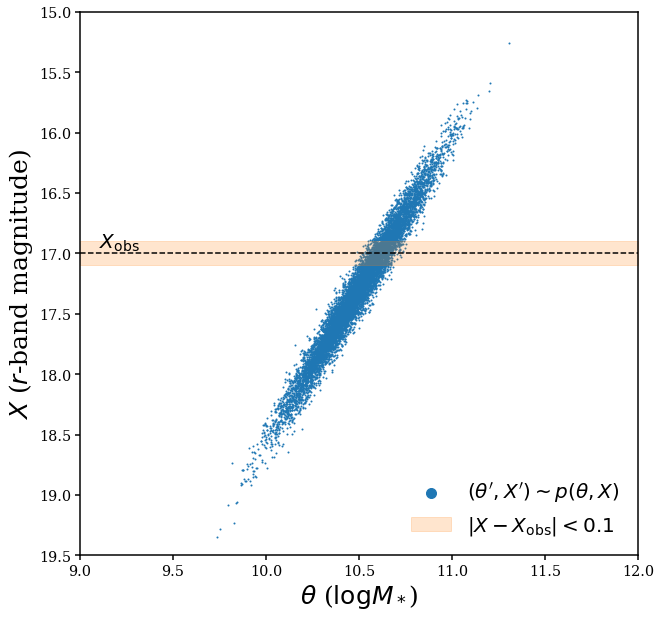

In [10]:
fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.scatter(thetas, Xs, s=1, label=r"$(\theta', X')\sim p(\theta, X)$")
sub.plot([9.0, 12.], [Xobs, Xobs], c='k', ls='--')
sub.text(9.1, 16.95, r'$X_{\rm obs}$', fontsize=20)
sub.fill_between([9.0, 12.], [16.9, 16.9], [17.1, 17.1], color='C1', alpha=0.2, label=r'$|X-X_{\rm obs}| < 0.1$')
sub.legend(loc='lower right', fontsize=20, markerscale=10)
sub.set_xlabel(r'$\theta$ ($\log M_*$)', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel('$X$ ($r$-band magnitude)', fontsize=25)
sub.set_ylim(19.5, 15.)

In ABC, we approximate the conditional statement using a "distance threshold":
$$p(\log M_*\,|\,X_{\rm obs}) \approx p(\log M_*\,|\,|X - X_{\rm obs}| < \epsilon)$$

For $\epsilon \rightarrow 0$, the approximation gets closer to the true posterior. For larger $\epsilon$, we overestimate the width of the posterior. Of course, as we decrease $\epsilon$, fewer samples of $(\theta', X')\sim p(\theta, X)$ will be included. So for our purposes we'll set $\epsilon = 0.1$.

In [11]:
abc_threshold = (np.abs(Xs - Xobs) < 0.1)

Text(0, 0.5, '$p(\\log M_*\\,|\\,X_{\\rm obs})$')

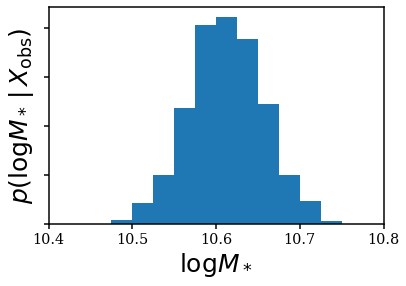

In [12]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
sub.hist(thetas[abc_threshold], range=(10., 11.), bins=40, density=True)
sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(10.4, 10.8)
sub.set_yticklabels([])
sub.set_ylabel(r'$p(\log M_*\,|\,X_{\rm obs})$', fontsize=25)

# 3. SBI Example 2: ABC in higher dimensions
Lets try a slightly more complicated problem and allow redshift to vary in our forward model. That way we can infer posteriors for both $\log M_*$ and redshift: 
$$p(\log M_*, z | X_{\rm obs}=19)$$

For our priors on  $\log M_*$ and $z$, lets use
$$p(\log M_*) = \mathcal{N}(10.5, 0.2)$$
$$p(z) = \mathcal{N}(0.2, 0.02)$$

In [39]:
Xobs = 19.

In [14]:
def forwardmodel1(logmstar, zred): 
  w, f = sed(logmstar, zred) # model SD
  r_nonoise = r_model(w, f) # model r-band magnitude
  r_noise = noise_model(r_nonoise) # forward modeled r-band magnitude
  return r_noise

In [15]:
thetas = np.random.normal(size=(10000,2))
thetas[:,0] *= 0.2
thetas[:,0] += 10.5

thetas[:,1] *= 0.02
thetas[:,1] += 0.2

In [16]:
Xs1 = np.array([forwardmodel1(tt[0], tt[1]) for tt in thetas])

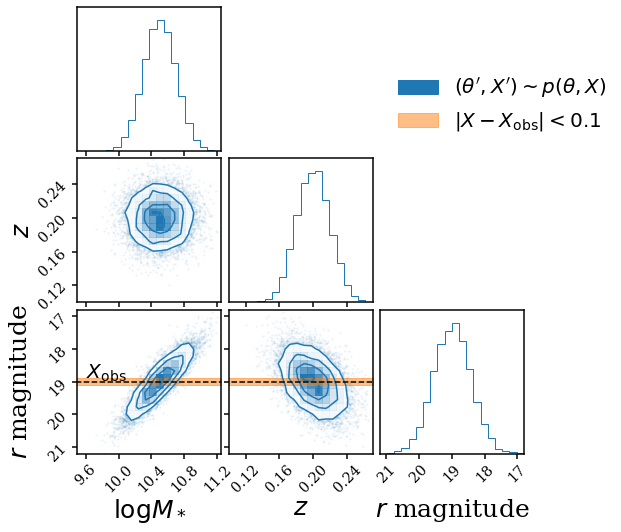

In [17]:
fig = corner.corner(np.concatenate([thetas, Xs1[:,None]], axis=1), 
                 labels=[r'$\log M_*$', '$z$', '$r$ magnitude'],
                 label_kwargs={'fontsize': 25},
                 range=[(9.5, 11.25), (0.1, 0.27), (21.2, 16.8)],
                 color='C0')

axes = np.array(fig.axes).reshape((3,3))
ax = axes[2,0]
ax.plot([9., 11.5], [Xobs, Xobs], c='k', ls='--')
ax.text(9.6, 18.9, r'$X_{\rm obs}$', fontsize=20)
ax.fill_between([9., 11.5], [Xobs - 0.1, Xobs - 0.1], [Xobs + 0.1, Xobs + 0.1], color='C1', alpha=0.5)

ax = axes[2,1]
ax.plot([0., 0.6], [Xobs, Xobs], c='k', ls='--')
ax.fill_between([0., 0.6], [Xobs - 0.1, Xobs - 0.1], [Xobs + 0.1, Xobs + 0.1], color='C1', alpha=0.5)

ax = axes[0, 2]
ax.fill_between([], [], [], color='C0', label=r"$(\theta', X')\sim p(\theta, X)$")
ax.fill_between([], [], [], color='C1', alpha=0.5, label=r'$|X-X_{\rm obs}| < 0.1$')
ax.legend(loc='lower left', fontsize=20)

Above is what the joint distribution $p(\theta, X)$ looks like in this example. Now we can use ABC to get posteriors for $X_{\rm obs}$!

In [21]:
abc_thresh = (np.abs(Xs1 - Xobs) < 0.1)
print('%i samples in ABC threshold' % np.sum(abc_thresh))

1354 samples in ABC threshold


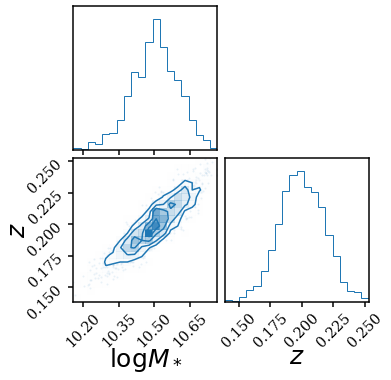

In [22]:
fig = corner.corner(thetas[abc_thresh], 
                    labels=[r'$\log M_*$', '$z$'], 
                    label_kwargs={'fontsize': 25},
                    color='C0')

Even with 10,000 samples from $(\theta', X')\sim p(\theta, X)$, once you start increasing the dimensionality, the number of samples within the ABC threshold starts to become problematic. You can imagine ABC is no longer feasible for the full dimensionality (12 free parameters) of the full `provabgs` model. 

# 4. SBI using normalizing flows
As I mentioned during the talk, a more efficient way of doing SBI is by using density estimation, where we can leverage the latest techniques from generative models in ML (*e.g.* normalizing flows). 

In the following section, I'll show you how to conduct SBI using normalizing flows using `sbi`, an easy to use python package. See
[Tejero-Cantero+(2020)](https://doi.org/10.21105/joss.02505) for details. 

We'll apply `sbi` to Example 3 using a Masked Autoregressive Flow (MAF; [Papamakarios+(2017)](https://ui.adsabs.harvard.edu/abs/2017arXiv170507057P/abstract)). 

In [23]:
!pip install sbi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53672 sha256=8913debac376104a8f50cf527321567d756a0a068c18e3a7c5ae6ca0e2589866
  Stored in directory: /root/.cache/pip/wheels/c8/5a/0f/13956ce5f76f1688d1394146cbe7620d28d4ac05b194d1d8ed
Successfully built nflows


In [24]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [25]:
# sbi requires setting a parameter range for when it later samples the posterior. 
# note that the package refers to this as the "prior"; however, in our case we're 
# just going to set uniform bounds. This is because our (theta, X) samples are
# already drawn from the prior, so it's already built into our training data. 
lower_bounds = torch.tensor([9., 0.0])
upper_bounds = torch.tensor([12., 0.6])

bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

Lets define a normalizing flow model. This is the model that estimates the conditional probability distribution --- i.e. posterior. Since we're estimating a relatively simple example, we'll go with some random architecture


In [26]:
nhidden = 128 
nblocks = 5

maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

now we can set up the SBI. Note that we use the SNPE module, which stands for Sequential Neural Posterior Estimation. We will *not* be using the sequential
feature, which allows us to sequentially generate more samples using our forward model. However, if you're interested the `sbi` package is fairly well documented with examples: https://www.mackelab.org/sbi/tutorial/16_implemented_methods/

In [29]:
anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

anpe.append_simulations(
            torch.as_tensor(thetas.astype(np.float32)).to('cpu'),
            torch.as_tensor(Xs1[:,None].astype(np.float32)).to('cpu'))

# estimate p(theta|X)
p_theta_x_est = anpe.train()

 Neural network successfully converged after 50 epochs.

In [30]:
qphi = anpe.build_posterior(p_theta_x_est)

In [40]:
posterior_samples = np.array(qphi.sample((10000,), 
                                x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                show_progress_bars=False).detach().to('cpu'))

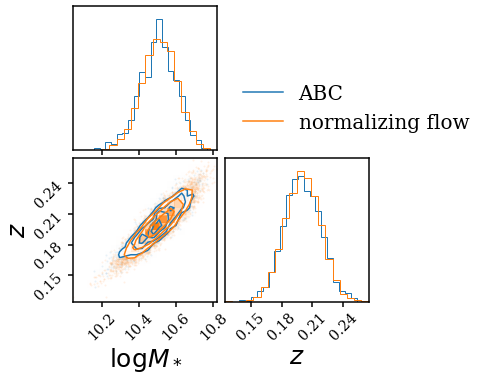

In [41]:
fig = corner.corner(thetas[abc_thresh], 
                    labels=[r'$\log M_*$', '$z$'], 
                    label_kwargs={'fontsize': 25},
                    color='C0', hist_kwargs={'density': True})
_ = corner.corner(posterior_samples, 
                  labels=[r'$\log M_*$', '$z$'], 
                  label_kwargs={'fontsize': 25},
                  color='C1', hist_kwargs={'density': True}, fig=fig)

axes = np.array(fig.axes).reshape(2,2)
ax = axes[0,1]
ax.plot([], [], c='C0', label='ABC')
ax.plot([], [], c='C1', label='normalizing flow')
ax.legend(loc='lower left', fontsize=20)

# 5. Amortized inference with SBI
One major advantage of SBI using density estimation is amortization. *i.e.* once we train the normalizing flow, we can plug in a different value of $X_{\rm obs}$ and get the posterior without retraining the normalizing flow. This is the premise behind `SEDflow` ([Hahn & Melchior 2022](https://changhoonhahn.github.io/SEDflow/current/)). 

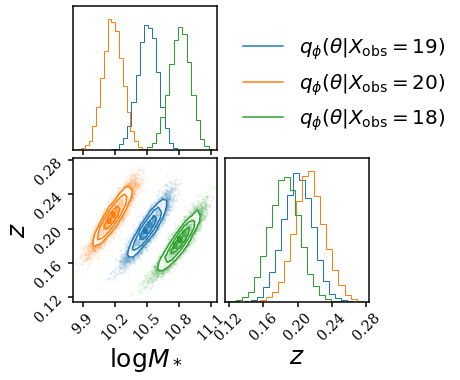

In [45]:
fig = corner.corner(posterior_samples, 
                  labels=[r'$\log M_*$', '$z$'], 
                  label_kwargs={'fontsize': 25},
                  color='C0', hist_kwargs={'density': True})

for i, _Xobs in enumerate([20, 18.]): 
  _samples = np.array(qphi.sample((10000,), 
                                x=torch.as_tensor(np.array([_Xobs]).astype(np.float32)).to('cpu'), 
                                show_progress_bars=False).detach().to('cpu'))
  _ = corner.corner(_samples, 
                  labels=[r'$\log M_*$', '$z$'], 
                  label_kwargs={'fontsize': 25},
                  color='C%i' % (i+1), hist_kwargs={'density': True}, fig=fig)

axes = np.array(fig.axes).reshape(2,2)
ax = axes[0,1]
ax.plot([], [], c='C0', label=r'$q_\phi(\theta|X_{\rm obs}=19)$')
ax.plot([], [], c='C1', label=r'$q_\phi(\theta|X_{\rm obs}=20)$')
ax.plot([], [], c='C2', label=r'$q_\phi(\theta|X_{\rm obs}=18)$')
ax.legend(loc='lower left', fontsize=20)

## **DANGER**
Like many machine learning techniques, SBI with normalizing flows will sometimes give you a posterior even if it's outside of the training data.

For example, $X_{\rm obs} = 15$ is well outside the the magnitude range
our training data $(\theta', X')\sim p(\theta, X)$. Yet ...

Text(0.5, 0.98, 'meaningless posterior')

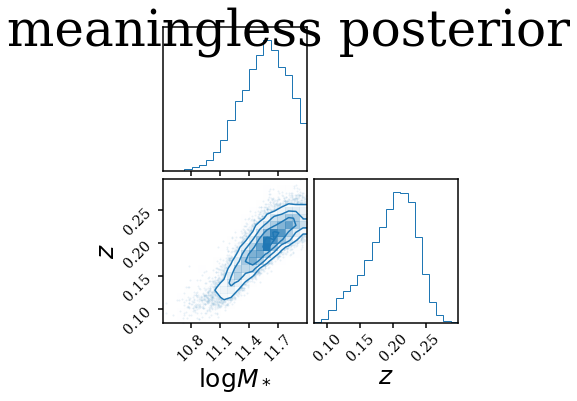

In [82]:
_samples = np.array(qphi.sample((10000,), 
                                x=torch.as_tensor(np.array([15]).astype(np.float32)).to('cpu'), 
                                show_progress_bars=False).detach().to('cpu'))
fig = corner.corner(_samples, 
                  labels=[r'$\log M_*$', '$z$'], 
                  label_kwargs={'fontsize': 25},
                  color='C0', hist_kwargs={'density': True})
fig.suptitle('meaningless posterior', fontsize=50)

Even if the posteriors *seem* sensible, like above --- they are meaningless. 

**Please make sure your machines learn responsibly**. 

# 6. More Realistic Application

So far all the examples have been toy models. Lets add some realism!

Try implementing: 
1. multiple bands of photometry
2. a magnitude dependent noise model

I've added some pseudo code to help you along

In [46]:
# load SDSS u, g, r, i, z-band filters
sdss_passes = specFilter.load_filters('sdss2010-*')

In [75]:
def sed(logmstar, beta0, zred): 
  ''' SPS model that outputs noiseless model SED given log(M*), a SFH NMF 
  coefficient and redshift. 
  '''
  # SPS parameters. Only log(M*) is a free parameter, the others are hardcoded
  # for simplicity
  theta_sps = np.array([
      logmstar,
      beta0, # beta0
      1.-beta0, # beta1
      0.0, # beta2
      0.0, # beta3
      0.0, # starburst component fraction
      1.0, # starburst time
      1e-3, # gamma0  
      1e-3, # gamma1
      1.0, # optical depth of birth cloud
      1.0, # optical depth of ISM 
      0.0  # dust index
      ])
  w, f = m_sps.sed(theta_sps, zred)
  return w, f


def sdss_mag_model(w, f): 
  ''' convolve model SED with r-band filter and return noiseless r-band magnitude
  '''
  flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
  maggies = sdss_passes.get_ab_maggies(flux_z, wavelength=w_z)
  return 22.5 - 2.5 * np.log10(np.array(maggies.as_array()[0].tolist()) * 1e9)

In [77]:
def noise_model(mag): 
  # implement noise model here!  
  return r + noise

def forwardmodel_realistic(logmstar, beta0, zred): 
  w, f = sed(logmstar, beta0, zred) # model SD
  mags_nonoise = sdss_mag_model(w, f) # model r-band magnitude
  mags_noise = noise_model(r_nonoise) # forward modeled r-band magnitude
  return mags_noise

generate the training data

In [ ]:
# sample parameters from prior
thetas = np.zeros((10000,3))
thetas[:,0] = # insert prior on logM*
thetas[:,1] = # insert prior on beta0. This is a coefficient for a NMF basis of the SFH. It can only be from 0 to 1
thetas[:,2] = # insert prior on redshift

# generate synthetic obsevation for each parameter
Xs_realistic = np.array([forwardmodel_realistic(tt[0], tt[1], tt[2]) for tt in thetas])

try plotting the joint distribution $p(\theta, X)$

train normalizing flow to estimate the posterior

derive posteriors for your "observations". But first make sure it's within the training data!